In [223]:
%matplotlib inline
from nltk.corpus import brown
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
import nltk
from collections import Counter
from itertools import chain

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Classifying Brown

As discussed previously, one of the first steps we wanted to take was to classify books into fiction and non fiction. In the brown corpus, this is pretty clear for most genres, with one exception. Humor (9 documents) is a mix of fiction and non-fiction. I couldn't immediately find information on which was which, so I just excluded it from the data.


In [106]:
df = pd.DataFrame({'fileid':[i for i in brown.fileids()]})
df['text'] = df.fileid.apply(lambda x: ' '.join(brown.words(fileids=x)))
df['category'] = df.fileid.apply(lambda x: brown.categories(fileids=x)[0])

In [107]:
category_dict={'adventure': 'Fiction',
              'belles_lettres': 'Nonfiction',
              'editorial': 'Nonfiction',
              'fiction': 'Fiction',
              'government': 'Nonfiction',
              'hobbies': 'Nonfiction',
              'humor': 'Humor',
              'learned': 'Nonfiction',
              'lore': 'Nonfiction',
              'mystery': 'Fiction',
              'news': 'Nonfiction',
              'religion': 'Nonfiction',
              'reviews': 'Nonfiction',
              'romance': 'Fiction',
              'science_fiction': 'Fiction'}
df['fiction'] = df.category.map(category_dict)
df = df[df.fiction!='Humor']

In [108]:
df.fiction.value_counts()

Nonfiction    374
Fiction       117
Name: fiction, dtype: int64

The data features a slight imbalance -- there are about three times as many nonfiction documents as there are fiction. This could pose a problem for classification, but as we will see, it turns out that simple models to a pretty good job on these data.

To evaluate performance, I set up a 10-fold cross validation experiment with a multinomial naiive bayes classifier. The input to this model is a very simple unigram bag-of-words. 

In [193]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [194]:
for train, test in rs.split(df.text):
    x_train = df.iloc[train]['text'].values
    y_train = le.transform(df.iloc[train]['fiction'].values)
    
    x_test = df.iloc[test]['text'].values
    y_test = le.transform(df.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for fiction class across 10 folds = 0.877488416474
SD of F1 score = 0.0713905528186


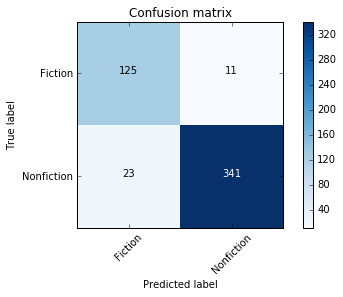

In [195]:
plot_confusion_matrix(conf, classes=le.classes_ )
print ('Average F1 score for fiction class across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

The figure above shows the confusion matrix for the problem. Clearly, this was not a terribly difficult task, but there's also a little room for improvement. To what extent can we replicate this on other data? We can test the same idea using the MASC data. Unfortunately, this dataset is quite a bit smaller.

# Classifying the MASC corpus

In [144]:
import lxml.etree as etree
from bs4 import BeautifulSoup
import glob

files = glob.glob('data/*/*.xml')
entities = {'person': 0, 'org':0, 'location':0, 'date':0}
text = []
category = []
fileid = []
for f in files:
    xml_data = open(f).read()
    soup = BeautifulSoup(xml_data, 'lxml')
    text.append(soup.text)
    category.append(re.findall('data/(.+)/',f)[0])
    fileid.append(re.findall('data/.+/(.+)',f)[0])

In [149]:
df_masc = pd.DataFrame({'fileid':[i for i in fileid],
                        'text':[i for i in text],
                       'category':[i for i in category]})

In [150]:
category_dict={'newspaper': 'Nonfiction',
              'essays': 'Nonfiction',
              'technical': 'Nonfiction',
              'fiction': 'Fiction',
              'travel_guides': 'Nonfiction',
              'non_fiction': 'Nonfiction',
              'ficlits': 'Fiction',
              'govt_docs': 'Nonfiction'}
df_masc['fiction'] = df_masc.category.map(category_dict)
df_masc.fiction.value_counts()

Nonfiction    85
Fiction       12
Name: fiction, dtype: int64

The imbalance here is quite a bit worse than the Brown corpus. There are nearly 7 times the number of nonfiction examples as fiction examples. Given how easy the previous classification problem was, this might pose a good test for how easy this problem is. 

Evaluation is the same as for the Brown Corpus, with the same classifier and features.

In [266]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_masc.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [267]:
for train, test in rs.split(df_masc.text):
    x_train = df_masc.iloc[train]['text'].values
    y_train = le.transform(df_masc.iloc[train]['fiction'].values)
    
    x_test = df_masc.iloc[test]['text'].values
    y_test = le.transform(df_masc.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for Fiction across 10 folds = 0.785714285714
SD of F1 score = 0.395123333884


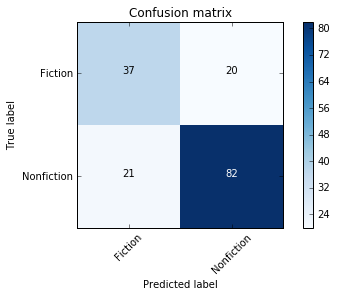

In [268]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

The performance here is a bit worse than the Brown corpus, though this isn't too surprising, as there's less data to work with here. However, it still appears that there's a good signal in these data for classification, as performance is still relatively good.

# Combined corpora

As both of these corpora are on the small side, we can get a better sense of performance by using the combined data on the same classification problem.

In [202]:
df_combined = pd.concat([df, df_masc])
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_combined.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [203]:
for train, test in rs.split(df_combined.text):
    x_train = df_combined.iloc[train]['text'].values
    y_train = le.transform(df_combined.iloc[train]['fiction'].values)
    
    x_test = df_combined.iloc[test]['text'].values
    y_test = le.transform(df_combined.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for Fiction across 10 folds = 0.874601531753
SD of F1 score = 0.075085701183


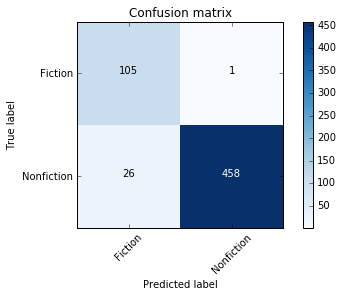

In [204]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

This performance is roughly on par with what we saw using just the brown corpus. If we want to see improvements, it seems as though we'll need to do some feature engineering or change the classifier. As a first approach, I'll incorporate some Part-of-speech features.

# Part-of-speech data

In [225]:
tag_words = lambda x: nltk.pos_tag(nltk.word_tokenize(x))
df_combined['tagged_data'] = df_combined.text.apply(tag_words)

all_tags = sorted(set(list(zip(*chain(*df_combined['tagged_data'])))[1]))

def add_pos_with_zero_counts(counter, keys_to_add):
    for k in keys_to_add:
        counter[k] = counter.get(k, 0)
    return counter

df_combined['pos_counts'] = df_combined['tagged_data'].apply(lambda x: Counter(list(zip(*x))[1]))
df_combined['pos_counts_with_zero'] = df_combined['pos_counts'].apply(lambda x: add_pos_with_zero_counts(x, all_tags))
df_combined['sent_vector'] = df_combined['pos_counts_with_zero'].apply(lambda x: [count for tag, count in sorted(x.most_common())])
df_tags = pd.DataFrame(df_combined['sent_vector'].tolist())
df_tags.columns = all_tags

In [257]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_combined.fiction)
#text_clf = Pipeline([('vect', CountVectorizer()),
#                    ('clf', MultinomialNB())])
count_vect = CountVectorizer()
clf = MultinomialNB()

In [258]:
for train, test in rs.split(df_combined.text):
    text_train = df_combined.iloc[train]['text'].values
    pos_train = df_tags.iloc[train]
    y_train = le.transform(df_combined.iloc[train]['fiction'].values)
    
    text_test = df_combined.iloc[test]['text'].values
    pos_test = df_tags.iloc[test]
    y_test = le.transform(df_combined.iloc[test]['fiction'].values)
    
    train_counts = count_vect.fit_transform(text_train)
    x_train = hstack([train_counts, pos_train])
    test_counts = count_vect.transform(text_test)
    x_test = hstack([test_counts, pos_test])
    
    
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for Fiction across 10 folds = 0.931592493784
SD of F1 score = 0.047386312465


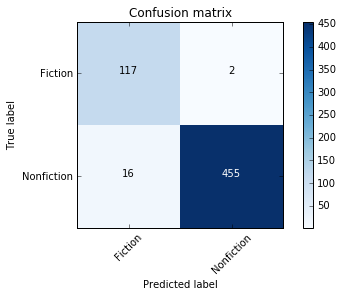

In [259]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

Adding the POS features had a positive effect on performance. We can see that the F1 score improved by a few points (from .87 to .93), and the variance of the performance across the folds has also gone down, (from a SD of .08 to .05), suggesting more stable performance on this task.